# Multi-Season Images

### Objectives
In this example, we're going to demonstrate how to work with images of same field taken in multiple seasons/time points. Due to the field management would vary in different growing stages, the difference between research plants and other objects (soil, weed) can sometimes be challenging to tell. It would make the segmentation easier if we can replicate plot coordinates learned from one image (``s1.tif``) to another image (``s2.tif``).

<img src="res/seasons/inputs.png" width=720>

### Obtain shapefiles from GRID
Run GRID normally on the image `s1.tif`. The output shapefiles allow us to replicate the plot coordinates to the next season (image).
<img src="res/seasons/s1_shp.png" width=600>

### Georeference the 2nd image by the 1st image
**NOTE**: This step can be skipped if the coordinate reference systsm (CRS) of two images matches well.

Before we work with ``s2.tif``, we have to ensure that both ``s1.tif`` and ``s2.tif`` share the same CRS. As the coordinates recorded by GPS may sometimes have error from one image to another, it's necessary to correct the georeference in <a href="https://qgis.org/en/site/">QGIS</a>. 
<img src="res/seasons/geo.png" width=700>

Here's a tutorial on [YouTube](https://www.youtube.com/watch?v=67j_HShwv8Y):

[![Tutorial](https://img.youtube.com/vi/67j_HShwv8Y/0.jpg)](https://www.youtube.com/watch?v=67j_HShwv8Y)

### Load shapefiles to replicate CRS
After we done georeferencing ``s2.tif``, we are ready to replicate the segmetation from `s1.tif` to `s2.tif`. We will load `s2.tif` as the input image this time, and load `s1.shp` as the input shapefile. 
<img src="res/seasons/load.png" width=700>

Users are required to crop the area of interest (AOI) and define the pixel of interest (POI). After that, the segmentation will be carried out exactly the same way as one in `s1.tif`.
<img src="res/seasons/results.png" width=700>

### Inspect tabular data

In [1]:
# imports
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import h5py as h5

In [3]:
# load tabular data from s1.tif and s2.tif
dt_s1 = pd.read_csv("s1_data.csv").loc[:, ["var", "area_veg", "NDVI"]]
dt_s2 = pd.read_csv("s2_data.csv").loc[:, ["var", "area_veg", "NDVI"]]

# rename column names
dt_s1.columns = ["id", "canopy_s1", "ndvi_s1"]
dt_s2.columns = ["id", "canopy_s2", "ndvi_s2"]

# merge two seasons of data by their IDs
dt = pd.merge(dt_s1, dt_s2)
dt

,id,canopy_s1,ndvi_s1,canopy_s2,ndvi_s2
0,unnamed_0,6139,0.079541,10756,0.057954
1,unnamed_9,5289,0.064362,11499,0.050158
2,unnamed_18,2175,0.057072,5965,0.042233
3,unnamed_27,5958,0.060194,15209,0.040483
4,unnamed_36,3293,0.067456,8394,0.048621
...,...,...,...,...,...
265,unnamed_233,7759,0.084310,10316,0.099573
266,unnamed_242,6455,0.050348,9391,0.068676
267,unnamed_251,4714,0.043048,10661,0.032655
268,unnamed_260,4696,0.045965,9780,0.044229


### Compute the correlation of NDVI between seasons

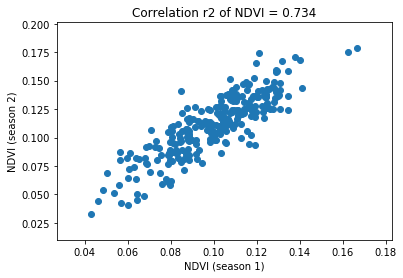

In [36]:
r2 = pearsonr(dt.ndvi_s1, dt.ndvi_s2)[0] ** 2
plt.title("Correlation r2 of NDVI = %.3f" % r2)
plt.xlabel("NDVI (season 1)")
plt.ylabel("NDVI (season 2)")
plt.scatter(dt.ndvi_s1, dt.ndvi_s2)

### Compute the correlation of canopy areas between seasons

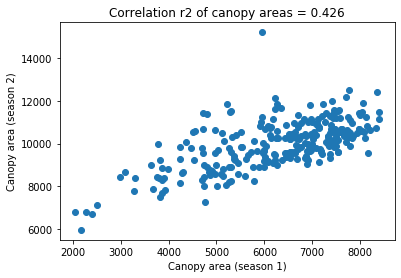

In [37]:
r2 = pearsonr(dt.canopy_s1, dt.canopy_s2)[0] ** 2
plt.title("Correlation r2 of canopy areas = %.3f" % r2)
plt.xlabel("Canopy area (season 1)")
plt.ylabel("Canopy area (season 2)")
plt.scatter(dt.canopy_s1, dt.canopy_s2)

### Select elite lines
We can select elite lines by ranking their change of canopy areas

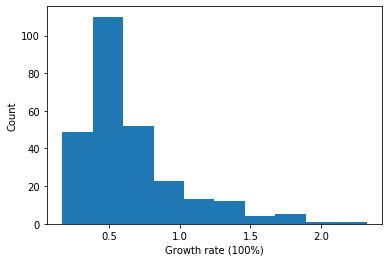

In [35]:
# use "growth rate" to represent their performance
dt.loc[:, "growth_rate"] = (dt.canopy_s2 - dt.canopy_s1) / dt.canopy_s1

# plot the performance in a histogram
plt.xlabel("Growth rate (100%)")
plt.ylabel("Count")
_ = plt.hist(dt.growth_rate.values)

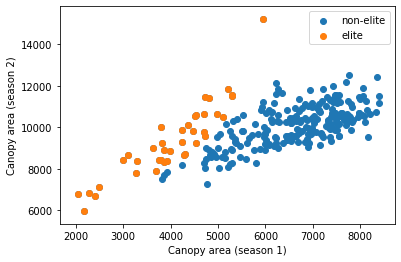

In [32]:
# we select lines with growth rate greater than 1
cutoff = 1
dt.loc[dt.growth_rate >= cutoff, "isElite"] = True
dt.loc[dt.growth_rate < cutoff, "isElite"] = False

# then we can replot the scatter plot by coloring the elite lines
plt.scatter(x=dt.canopy_s1, 
            y=dt.canopy_s2, 
            label="non-elite")
plt.scatter(x=dt[dt.isElite].canopy_s1, 
            y=dt[dt.isElite].canopy_s2, 
            label="elite")
plt.xlabel("Canopy area (season 1)")
plt.ylabel("Canopy area (season 2)")
plt.legend()

In [18]:
# rank their performance
dt.sort_values(by="growth_rate", ascending=False, inplace=True)
dt

,id,canopy_s1,ndvi_s1,canopy_s2,ndvi_s2,growth_rate,isElite
6,unnamed_54,2044,0.064161,6793,0.044786,2.323386,True
63,unnamed_29,2274,0.116536,6812,0.094472,1.995602,True
105,unnamed_138,2498,0.104650,7121,0.113467,1.850681,True
253,unnamed_125,2988,0.070304,8435,0.069946,1.822959,True
256,unnamed_152,3094,0.078514,8665,0.060872,1.800582,True
...,...,...,...,...,...,...,...
170,unnamed_185,7543,0.124144,9593,0.149356,0.271775,False
87,unnamed_245,7795,0.093975,9883,0.123432,0.267864,False
26,unnamed_234,8109,0.087209,10260,0.107430,0.265261,False
172,unnamed_203,7375,0.113576,9316,0.146696,0.263186,False


In [19]:
# extract the top-3 IDs
id_elite = dt[:3].id.values
id_elite

array(['unnamed_54', 'unnamed_29', 'unnamed_138'], dtype=object)

### Insepct the elite lines

In [29]:
# define a function that can extract specific items from h5 files
# in the h5 file, <ID name> + "_raw" stands for a image without removing noise and shaded areas
# it allows us to better inspect the image

def extract_imgs_from_h5(filename, ids):
    ls_imgs = []  
    with h5.File(filename, "r") as f:
        for id in ids:
            img = f[id + "_raw"][:]
            ls_imgs += [np.swapaxes(img, 0, 1)] # use np.swapaxes() to rotate image by 90° 
    return ls_imgs

In [30]:
# extract images of elite lines from two seasons
imgs_s1 = extract_imgs_from_h5("s1.h5", id_elite)
imgs_s2 = extract_imgs_from_h5("s2.h5", id_elite)

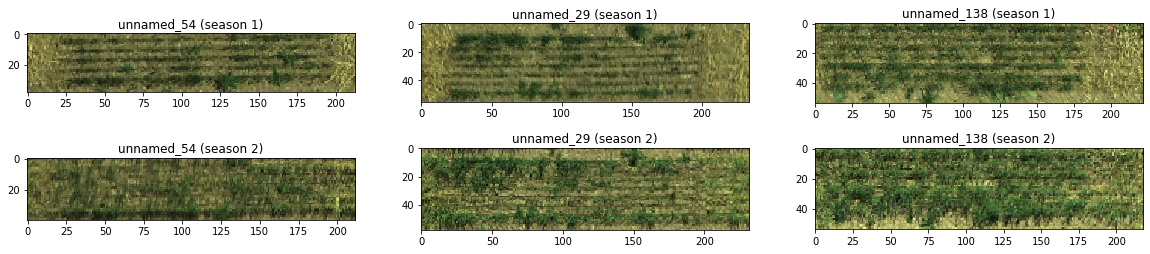

In [31]:
# plot the images
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
plt.subplots_adjust(hspace=0, bottom=0, top=.35)
for i in range(3):
    axes[0, i].imshow(imgs_s1[i])
    axes[0, i].set_title(id_elite[i] + (" (season 1)"))
    axes[1, i].imshow(imgs_s2[i])
    axes[1, i].set_title(id_elite[i] + (" (season 2)"))
